In [1]:
import json
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
from typing import List
import torch
import numpy as np
import json
import warnings
from typing import Dict, Any, Union, List, Dict
import numpy as np
import datasets
from transformers import AutoTokenizer, AutoModel, AutoConfig

def convert_numpy(obj: Union[Dict, list, np.ndarray, np.generic]) -> Any:
    """Recursively convert numpy objects in nested dictionaries or lists to native Python types."""
    if isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(i) for i in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert numpy arrays to lists
    elif isinstance(obj, (np.integer, np.floating)):
        return obj.item()  # Convert numpy scalars to native Python scalars
    elif isinstance(obj, np.float32):
        return float(obj)
    else:
        return obj  # Return the object as-is if it's neither a dict, list, nor numpy type


def load_model(model_path: str, use_fp16: bool = False):
    model_config = AutoConfig.from_pretrained(model_path, trust_remote_code=True)
    model = AutoModel.from_pretrained(model_path, trust_remote_code=True)
    model.eval()
    model.cuda()
    if use_fp16:
        model = model.half()
    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True, trust_remote_code=True)

    return model, tokenizer


def pooling(pooler_output, last_hidden_state, attention_mask=None, pooling_method="mean"):
    if pooling_method == "mean":
        last_hidden = last_hidden_state.masked_fill(~attention_mask[..., None].bool(), 0.0)
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
    elif pooling_method == "cls":
        return last_hidden_state[:, 0]
    elif pooling_method == "pooler":
        return pooler_output
    else:
        raise NotImplementedError("Pooling method not implemented!")


def set_default_instruction(model_name, is_query=True, is_zh=False):
    instruction = ""
    if "e5" in model_name.lower():
        if is_query:
            instruction = "query: "
        else:
            instruction = "passage: "

    if "bge" in model_name.lower():
        if is_query:
            if "zh" in model_name.lower() or is_zh:
                instruction = "为这个句子生成表示以用于检索相关文章："
            else:
                instruction = "Represent this sentence for searching relevant passages: "

    return instruction


def parse_query(model_name, query_list, instruction=None):
    """
    processing query for different encoders
    """

    def is_zh(str):
        import unicodedata

        zh_char = 0
        for c in str:
            try:
                if "CJK" in unicodedata.name(c):
                    zh_char += 1
            except:
                continue
        if len(str) == 0:
            return False
        if zh_char / len(str) > 0.2:
            return True
        else:
            return False

    if isinstance(query_list, str):
        query_list = [query_list]

    if instruction is not None:
        instruction = instruction.strip() + " "
    else:
        instruction = set_default_instruction(model_name, is_query=True, is_zh=is_zh(query_list[0]))
    print(f"Use `{instruction}` as retreival instruction")

    query_list = [instruction + query for query in query_list]

    return query_list

class Encoder:
    """
    Encoder class for encoding queries using a specified model.

    Attributes:
        model_name (str): The name of the model.
        model_path (str): The path to the model.
        pooling_method (str): The method used for pooling.
        max_length (int): The maximum length of the input sequences.
        use_fp16 (bool): Whether to use FP16 precision.
        instruction (str): Additional instructions for parsing queries.

    Methods:
        encode(query_list: List[str], is_query=True) -> np.ndarray:
            Encodes a list of queries into embeddings.
    """

    def __init__(self, model_name, model_path, pooling_method, max_length, use_fp16, instruction):
        self.model_name = model_name
        self.model_path = model_path
        self.pooling_method = pooling_method
        self.max_length = max_length
        self.use_fp16 = use_fp16
        self.instruction = instruction

        self.model, self.tokenizer = load_model(model_path=model_path, use_fp16=use_fp16)

    @torch.inference_mode()
    def encode(self, query_list: List[str], is_query=True) -> np.ndarray:
        query_list = parse_query(self.model_name, query_list, self.instruction)

        inputs = self.tokenizer(
            query_list, max_length=self.max_length, padding=True, truncation=True, return_tensors="pt"
        )
        inputs = {k: v.cuda() for k, v in inputs.items()}

        if "T5" in type(self.model).__name__:
            # T5-based retrieval model
            decoder_input_ids = torch.zeros((inputs["input_ids"].shape[0], 1), dtype=torch.long).to(
                inputs["input_ids"].device
            )
            output = self.model(**inputs, decoder_input_ids=decoder_input_ids, return_dict=True)
            query_emb = output.last_hidden_state[:, 0, :]

        else:
            output = self.model(**inputs, return_dict=True)
            query_emb = pooling(
                output.pooler_output, output.last_hidden_state, inputs["attention_mask"], self.pooling_method
            )
        query_emb = torch.nn.functional.normalize(query_emb, dim=-1)
        query_emb = query_emb.detach().cpu().numpy()
        query_emb = query_emb.astype(np.float32, order="C")
        return query_emb

/home/u2023100837/anaconda3/envs/jjj2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open('/home/u2023100837/workspace/flashrag_work/rag_critic/jl/error_type_frequency.txt','r') as f:
    data = f.readlines()
final_error_type = []
for line in data:
    line = line.strip("\n")
    times = int(line.split(":")[-1])
    if times < 10:
        continue
    error_type = line.split(":")[0].strip()
    final_error_type.append(error_type)

In [4]:
encoder = Encoder(
    model_name='bge-m3', 
    model_path='/home/u2023100837/model/bge-m3', 
    pooling_method='cls', 
    max_length=128, 
    use_fp16=True,
    instruction=None
)

In [5]:
embeddings = encoder.encode(final_error_type, is_query=False)

Use `Represent this sentence for searching relevant passages: ` as retreival instruction


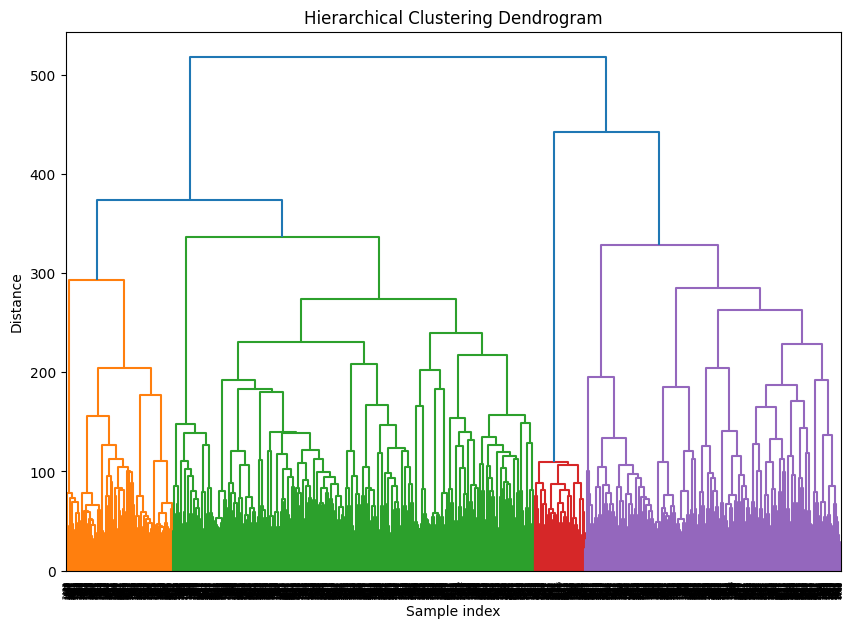

-----
Misalignment with Golden Answer
Golden Answer Mismatch
Irrelevant Golden Answer
Alignment with Golden Answer
Incorrect Golden Answer
Golden Answer Error
Golden Answer Inconsistency
Golden Answer Discrepancy
Inconsistent with Golden Answer
Contradiction with Golden Answer
Mismatch with Golden Answer
Mismatched Golden Answer
Misinterpretation of Golden Answer
Golden Answer Misalignment
Golden Answer Irrelevance
Discrepancy with Golden Answer
Failure to Utilize Golden Answer
Misalignment Between Question and Golden Answer
Golden Answer Inaccuracy
Inconsistent Golden Answer
Relevance to Golden Answer
Failure to Align with Golden Answer
Inadequate Alignment with Golden Answer
Potential Golden Answer Error
Failure to Match Golden Answer
Discrepancy Between Model and Golden Answer
Lack of Alignment with Golden Answer
Failure to Use Golden Answer
Golden Answer Incompleteness
Alignment with Golden Answer Error
Misalignment Between Prediction and Golden Answer
Prompt-Golden Answer Mismatch

In [6]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler

# 假设你的数据存储在 `embeddings` 变量中
# embeddings = np.array(...)  # 这里填入你的数据

# 数据预处理（标准化）
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# 使用 linkage 进行分层聚类，方法为 'ward'，它是基于最小化每个聚类的平方误差来合并聚类
Z = linkage(embeddings_scaled, method='ward')

# 绘制树状图（dendrogram）
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

# 根据树状图选择聚类的数量，假设我们选择了3个聚类
from scipy.cluster.hierarchy import fcluster

# fcluster函数根据给定的距离阈值或者聚类数来切割树状图
max_d = 10  # 你可以根据树状图选择合适的聚类数
labels = fcluster(Z, max_d, criterion='maxclust')

# 输出每个聚类的样本
for label in np.unique(labels):
    print("-----")
    select_ids = np.where(labels == label)[0]
    select_errors = [final_error_type[id] for id in select_ids]
    for error in select_errors:
        print(error)
    #print(f"Cluster {label}: {np.where(labels == label)[0]}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Estimated number of clusters: 0
Estimated number of noise points: 3215
Silhouette Score cannot be calculated with less than 2 clusters.


/home/u2023100837/anaconda3/envs/jjj2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_29744/993426980.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


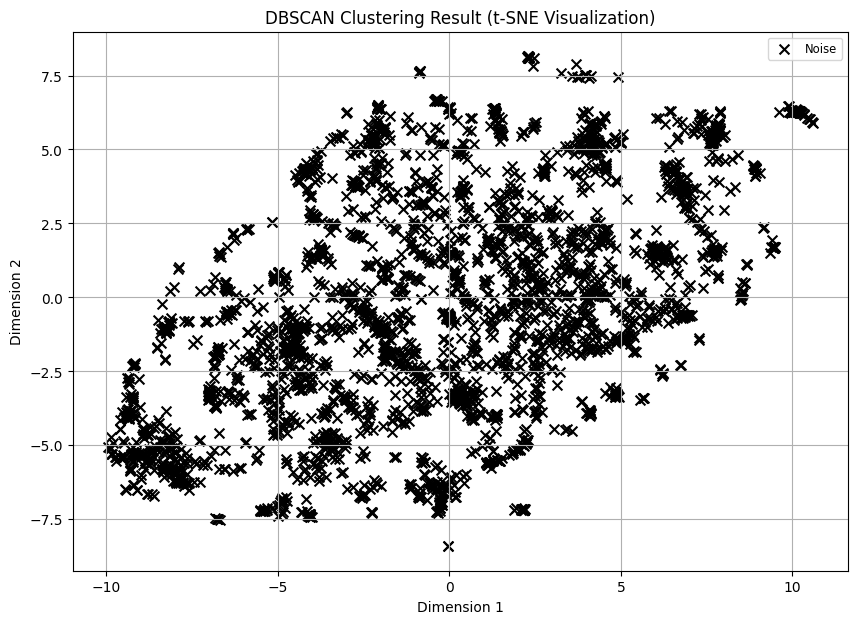

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 假设你的 embedding 数据在一个 (200, 1024) 的 NumPy 数组中
# 用随机数据生成器模拟（请替换为你的真实数据）
# Step 1: 数据标准化
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 2: 使用 DBSCAN 进行聚类
# 设置初始参数（可以调节以获得更好的效果）
eps = 0.5  # 邻域半径
min_samples = 5  # 每个簇的最小点数

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(embeddings_scaled)

# Step 3: 检查聚类结果
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)  # 计算簇数量（不包括噪声点）
n_noise = list(cluster_labels).count(-1)  # 噪声点数量

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# 如果聚类有效（至少有 2 个簇），计算轮廓系数
if n_clusters > 1:
    silhouette_avg = silhouette_score(embeddings_scaled, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")
else:
    print("Silhouette Score cannot be calculated with less than 2 clusters.")

# Step 4: 使用 t-SNE 降维
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(embeddings_scaled)

# Step 5: 可视化聚类结果
plt.figure(figsize=(10, 7))
unique_labels = set(cluster_labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for label in unique_labels:
    if label == -1:  # 噪声点
        color = 'k'
        marker = 'x'
        label_name = 'Noise'
    else:
        color = colors(label)
        marker = 'o'
        label_name = f'Cluster {label}'
    
    cluster_points = embeddings_2d[cluster_labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], label=label_name, s=50, marker=marker)

plt.title('DBSCAN Clustering Result (t-SNE Visualization)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(loc='best', fontsize='small')
plt.grid()
plt.show()


Cluster Details:
Cluster 0: 118 errors
['Contextual Understanding Error' 'Lack of Contextual Understanding'
 'Contextual Misunderstanding' 'Contextual Misinterpretation'
 'Context Misinterpretation' 'Lack of Context' 'Contextual Understanding'
 'Lack of Contextual Relevance' 'Misinterpretation of Context'
 'Lack of Contextual Depth' 'Lack of Contextual Information'
 'Context Misunderstanding' 'Lack of Contextual Awareness'
 'Context Ignorance' 'Missing Historical Context'
 'Historical Context Missing' 'Contextual Inference Error'
 'Context Utilization Error' 'Lack of Context Understanding'
 'Context Understanding Error' 'Contextual Error' 'Missing Context'
 'Contextual Information Missing' 'Contextual Inconsistency'
 'Contextual Inaccuracy' 'Lack of Context Awareness'
 'Missing Contextual Information' 'Lack of Contextual Detail'
 'Context Utilization' 'Lack of Cultural Context' 'Contextual Accuracy'
 'Context Dependency' 'Cultural Sensitivity' 'Lack of Personal Context'
 'Lack of Conte

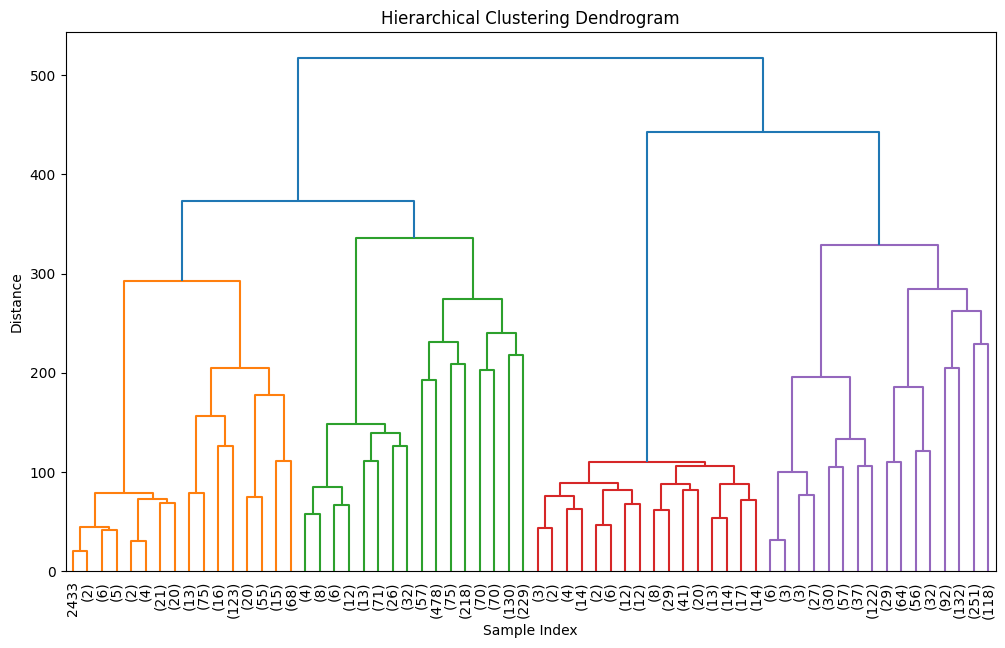

/home/u2023100837/anaconda3/envs/jjj2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


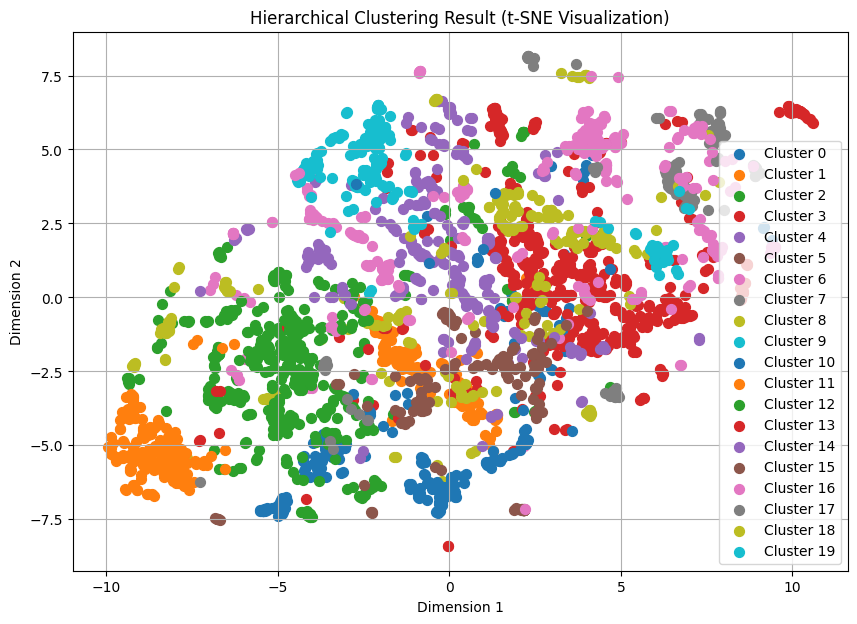

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage

# 假设你的 embedding 数据在一个 (200, 1024) 的 NumPy 数组中
# 用随机数据生成器模拟（请替换为你的真实数据）
# Step 1: 数据标准化

# Step 1: 数据标准化
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)
error_types = np.array(final_error_type)
# Step 2: 层次聚类（Agglomerative Clustering）
# 使用欧几里得距离和 Ward 方法
n_clusters = 20  # 你可以选择期望的簇数
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = hierarchical.fit_predict(embeddings_scaled)

# Step 3: 打印每个簇的 error types
print("Cluster Details:")
for cluster_id in range(n_clusters):
    cluster_errors = error_types[cluster_labels == cluster_id]
    print(f"Cluster {cluster_id}: {len(cluster_errors)} errors")
    print(cluster_errors)
    print("-" * 50)

# Step 4: 可视化：绘制层次树状图（Dendrogram）
plt.figure(figsize=(12, 7))
Z = linkage(embeddings_scaled, method='ward')  # 计算层次聚类的链接矩阵
dendrogram(Z, truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Step 5: 使用 t-SNE 降维进行聚类结果可视化
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(embeddings_scaled)

# 绘制聚类结果
plt.figure(figsize=(10, 7))
for cluster_id in range(n_clusters):
    cluster_points = embeddings_2d[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', s=50)

plt.title('Hierarchical Clustering Result (t-SNE Visualization)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid()
plt.show()


In [13]:
result = {}
for cluster_id in range(n_clusters):
    cluster_errors = error_types[cluster_labels == cluster_id].tolist()
    result[cluster_id] = cluster_errors
with open('result.json','w') as f:
    json.dump(result, f, indent=4)

In [12]:
cluster_errors.tolist()

['Entity Confusion',
 'Topic Confusion',
 'Fact Confusion',
 'Confusion of Entities',
 'Source Confusion',
 'Domain Confusion',
 'Fact Conflation',
 'Confusion Between Similar Entities',
 'Identity Confusion',
 'Date Confusion',
 'Conceptual Confusion',
 'Confusion with Similar Entities',
 'Contextual Confusion',
 'Information Conflation',
 'Unit Conversion Error',
 'Version Confusion',
 'Confusion of Similar Entities',
 'Event Confusion',
 'Name Confusion',
 'Category Confusion',
 'Terminology Confusion',
 'Confusion Between Entities',
 'Entity Conflation',
 'Concept Conflation',
 'Title Confusion',
 'Concept Confusion',
 'Version Mismatch',
 'Conflation of Information',
 'Confusion of Terms',
 'Content Confusion',
 'Subject Confusion',
 'Confusion Between Similar Concepts',
 'Confusion of Individuals',
 'Confusion with Similar Content',
 'Confusion of Concepts',
 'Conflation of Entities',
 'Conflation of Concepts',
 'Confusion of Events',
 'Year Confusion',
 'Genre Confusion',
 'Chro

In [9]:
for cluster_id in range(n_clusters):
    cluster_errors = error_types[cluster_labels == cluster_id][:20]
    print(f"Cluster {cluster_id}: {len(cluster_errors)} errors")
    print(cluster_errors)
    print("-" * 50)

Cluster 0: 20 errors
['Contextual Understanding Error' 'Lack of Contextual Understanding'
 'Contextual Misunderstanding' 'Contextual Misinterpretation'
 'Context Misinterpretation' 'Lack of Context' 'Contextual Understanding'
 'Lack of Contextual Relevance' 'Misinterpretation of Context'
 'Lack of Contextual Depth' 'Lack of Contextual Information'
 'Context Misunderstanding' 'Lack of Contextual Awareness'
 'Context Ignorance' 'Missing Historical Context'
 'Historical Context Missing' 'Contextual Inference Error'
 'Context Utilization Error' 'Lack of Context Understanding'
 'Context Understanding Error']
--------------------------------------------------
Cluster 1: 20 errors
['Incomplete Information' 'Incomplete Coverage' 'Incomplete Explanation'
 'Incomplete Analysis' 'Incomplete Historical Context'
 'Insufficient Information' 'Insufficient Contextual Understanding'
 'Content Incompleteness' 'Inadequate Contextual Understanding'
 'Insufficient Context' 'Insufficient Context Utilization